In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [27]:
filename = './exchange_data/BTC_1h_return.csv'

In [28]:
data = pd.read_csv(filename)

In [29]:
_sigma = data.Return.std()
_max_ret = data.Return.max()

In [30]:
_sigma

0.008243230917394779

In [31]:
_max_ret

0.1738398892181356

In [32]:
len(np.arange(sigma, max_ret, 0.001))

166

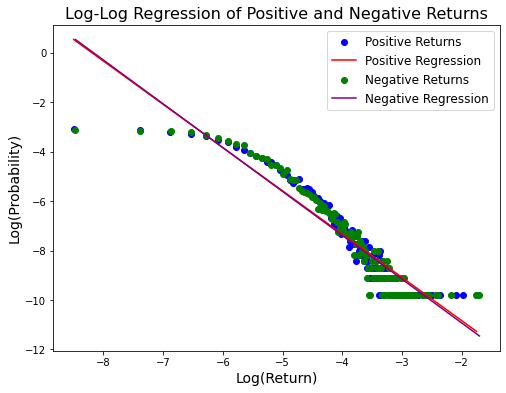

In [33]:
# Load the data from the csv file
data = pd.read_csv(filename)

# Calculate the histogram of returns
hist, edges = np.histogram(data['Return'], bins='auto')

# Calculate the probabilities of each return value
prob = hist / len(data['Return'])

# Remove any probabilities and corresponding returns that are equal to zero
pos_prob = prob[edges[:-1] > 0]
pos_ret = edges[:-1][edges[:-1] > 0]
neg_prob = prob[edges[:-1] < 0]
neg_ret = edges[:-1][edges[:-1] < 0]

pos_mask = pos_prob > 0
neg_mask = neg_prob > 0

pos_prob = pos_prob[pos_mask]
pos_ret = pos_ret[pos_mask]
neg_prob = neg_prob[neg_mask]
neg_ret = neg_ret[neg_mask]

# Calculate the natural logarithm of positive and negative returns and probabilities
log_pos_ret = np.log(pos_ret)
log_pos_prob = np.log(pos_prob)
log_neg_ret = np.log(-neg_ret)
log_neg_prob = np.log(neg_prob)

# Fit linear regression for the positive part of the distribution
pos_model = sm.OLS(log_pos_prob, sm.add_constant(log_pos_ret))
pos_results = pos_model.fit()

# Fit linear regression for the negative part of the distribution
neg_model = sm.OLS(log_neg_prob, sm.add_constant(log_neg_ret))
neg_results = neg_model.fit()

# Plot the regression lines for the positive and negative parts of the distribution
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(log_pos_ret, log_pos_prob, label='Positive Returns', color='blue')
ax.plot(log_pos_ret, pos_results.predict(sm.add_constant(log_pos_ret)), label='Positive Regression', color='red')
ax.scatter(log_neg_ret, log_neg_prob, label='Negative Returns', color='green')
ax.plot(log_neg_ret, neg_results.predict(sm.add_constant(log_neg_ret)), label='Negative Regression', color='purple')
ax.set_title('Log-Log Regression of Positive and Negative Returns', fontsize=16)
ax.set_xlabel('Log(Return)', fontsize=14)
ax.set_ylabel('Log(Probability)', fontsize=14)
ax.legend(fontsize=12)
plt.show()


In [34]:
def get_dist(data, bins=100):
    hist, edges = np.histogram(data['Return'], bins=bins)
    # Calculate the probabilities of each return value
    prob = hist / len(data['Return'])

    # Remove any probabilities and corresponding returns that are equal to zero
    pos_prob = prob[edges[:-1] > 0]
    pos_ret = edges[:-1][edges[:-1] > 0]
    neg_prob = prob[edges[:-1] < 0]
    neg_ret = edges[:-1][edges[:-1] < 0]

    pos_mask = pos_prob > 0
    pos_prob = pos_prob[pos_mask]
    pos_ret = pos_ret[pos_mask]

    neg_mask = neg_prob > 0
    neg_prob = neg_prob[neg_mask]
    neg_ret = neg_ret[neg_mask]

    return pos_ret, pos_prob, neg_ret, neg_prob

In [35]:
def OLS_fit(x, y, R2_only=True):
    model = sm.OLS(y, sm.add_constant(x))
    results = model.fit()
    R2 = results.rsquared
    if R2_only:
        return R2
    beta = results.params[1]
    alpha = results.params[0]
    return beta, alpha, R2

In [36]:
def get_boundary_value(ret_data):
    def sum_R2(ret, prob, pivot, pos):
        if pos:
            power_x = ret[ret > pivot]
            power_y = prob[ret > pivot]
            power_R2 = OLS_fit(np.log(power_x), np.log(power_y))
            # exp_x = ret[ret < pivot]
            # exp_y = prob[ret < pivot]
            # exp_R2 = OLS_fit(exp_x, np.log(exp_y))
        else:
            power_x = ret[ret < pivot]
            power_y = prob[ret < pivot]
            power_R2 = OLS_fit(np.log(-power_x), np.log(power_y))
            # exp_x = ret[ret > pivot]
            # exp_y = prob[ret > pivot]
            # exp_R2 = OLS_fit(-exp_x, np.log(exp_y))
            
        return power_R2  
        # return power_R2 + exp_R2

    pos_ret, pos_prob, neg_ret, neg_prob = get_dist(ret_data, bins=100)
    # print(np.isnan(pos_ret).any())
    # print(np.isnan(neg_ret).any())

    pos_start, pos_end = pos_ret[10], pos_ret[-1]
    neg_start, neg_end = neg_ret[1], neg_ret[-10]
    print(pos_ret)
    print(neg_ret)
    tick = 5e-5
    pos_R2, neg_R2 = [], []
    for pos_pivot in np.arange(pos_start, pos_end, tick):
        pos_R2.append([pos_pivot, sum_R2(pos_ret, pos_prob, pos_pivot, True)])
    for neg_pivot in np.arange(neg_start, neg_end, tick):
        neg_R2.append([neg_pivot, sum_R2(neg_ret, neg_prob, neg_pivot, False)])
        # break
    
    return pos_R2, neg_R2
    

In [37]:
a, b = get_boundary_value(data)

[0.00298167 0.00654122 0.01010076 0.01366031 0.01721985 0.0207794
 0.02433895 0.02789849 0.03145804 0.03501759 0.03857713 0.04213668
 0.04569622 0.04925577 0.05281532 0.05637486 0.05993441 0.06349396
 0.07417259 0.08129169 0.08841078 0.09197033 0.1204467  0.13824443
 0.17028034]
[-0.18211473 -0.17499564 -0.11448336 -0.09312608 -0.08956653 -0.07888789
 -0.0717688  -0.06464971 -0.06109016 -0.05753062 -0.05397107 -0.05041152
 -0.04685198 -0.04329243 -0.03973288 -0.03617334 -0.03261379 -0.02905425
 -0.0254947  -0.02193515 -0.01837561 -0.01481606 -0.01125652 -0.00769697
 -0.00413742 -0.00057788]


/home/ruixuan/yes/envs/NLP/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ruixuan/yes/envs/NLP/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [38]:
max(a, key=lambda x:x[1])

[0.056377132288292636, 0.6932211919915777]

In [39]:
max([x for x in b if not np.isnan(x[1])], key=lambda x:x[1])

[-0.03614564181147592, 0.6664595438981691]

In [40]:
data[data.Return > 0].Return.mean()

0.004735799675549259

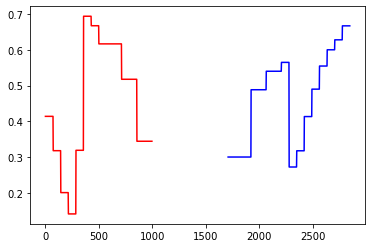

In [41]:
plt.plot(range(len(a)), [x[1] for x in a], color='r')
plt.plot(range(len(b)), [x[1] for x in b], color='b')

In [42]:
def log_log_regression(filename, jpgname, logx=True, ret_ranges=[(-0.01, 0.01)]):
    # Load the data from the csv file
    raw_data = pd.read_csv(filename)

    def global_scatter_plot(log_pos_ret, log_pos_prob, log_neg_ret, log_neg_prob):
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(log_pos_ret, log_pos_prob, label='Positive Returns', color='blue', alpha=0.2)
        ax.scatter(log_neg_ret, log_neg_prob, label='Negative Returns', color='red', alpha=0.2)
        ax.set_title('Regression of Probability vs. Positive and Negative Returns', fontsize=16)
        if logx:
            ax.set_xlabel('log(Return)', fontsize=14)
            ax.set_ylabel('log(Probability)', fontsize=14)
        else:
            ax.set_xlabel('Return', fontsize=14)
            ax.set_ylabel('log(Probability)', fontsize=14)
        ax.legend(fontsize=12)
        return fig, ax

    def OLS_fit_plot(log_pos_ret, log_pos_prob, figax, pos):
        pos_model = sm.OLS(log_pos_prob, sm.add_constant(log_pos_ret))
        pos_results = pos_model.fit()
        pos_beta = pos_results.params[1]
        pos_alpha = pos_results.params[0]
        
        fig, ax = figax
        if pos:
            ax.plot(log_pos_ret, pos_results.predict(sm.add_constant(log_pos_ret)), 
            label='Positive Regression', color='blue')
            ax.text(0.1, 0.4, f"pos: beta={pos_beta:.2f}, alpha={pos_alpha:.2f}", transform=ax.transAxes, size=14)
            print(f"Positive Returns: beta={pos_beta:.3f}, alpha={pos_alpha:.3f}")

        else:
            ax.plot(log_pos_ret, pos_results.predict(sm.add_constant(log_pos_ret)), label='Negative Regression', color='red')
            ax.text(0.1, 0.3, f"neg: beta={pos_beta:.2f}, alpha={pos_alpha:.2f}", transform=ax.transAxes, size=14)
            print(f"Negative Returns: beta={pos_beta:.3f}, alpha={pos_alpha:.3f}")
        ax.legend(fontsize=12)
        # plt.savefig(jpgname)
        # plt.show()
        return fig, ax
    
    # range_data = raw_data[(raw_data['Return'] >= ret_ranges[0][0]) & (raw_data['Return'] <= ret_ranges[-1][-1])]
    conditions = None
    for ret_range in ret_ranges:
        new_condition = (raw_data['Return'] >= ret_range[0]) & (raw_data['Return'] <= ret_range[1])
        if conditions is None:
            conditions = new_condition
        else:
            conditions = conditions | new_condition

    range_data = raw_data[conditions]

    pos_ret, pos_prob, neg_ret, neg_prob = get_dist(range_data)

    log_pos_prob = np.log(pos_prob)
    log_neg_prob = np.log(neg_prob)

    if logx:
        pos_ret = np.log(pos_ret)
        neg_ret = np.log(-neg_ret)
    else:
        pos_ret = pos_ret
        neg_ret = -neg_ret

    figax = global_scatter_plot(pos_ret, log_pos_prob, neg_ret, log_neg_prob)
    
    for ret_range in ret_ranges:
        # Filter returns within the specified range
        data = raw_data[(raw_data['Return'] >= ret_range[0]) & (raw_data['Return'] <= ret_range[1])]

        pos_ret, pos_prob, neg_ret, neg_prob = get_dist(data)
        if logx:
            pos_ret = np.log(pos_ret)
            neg_ret = np.log(-neg_ret)
        else:
            pos_ret = pos_ret
            neg_ret = -neg_ret

        if ret_range[1] >= 0:
            log_pos_prob = np.log(pos_prob)
            figax = OLS_fit_plot(pos_ret, log_pos_prob, figax, True)

        if ret_range[0] <= 0:
            log_neg_prob = np.log(neg_prob)
            figax = OLS_fit_plot(neg_ret, log_neg_prob, figax, False)
    figax[0].savefig(f'./Bouchaud_log_log/{jpgname}.jpg', dpi=300)



Positive Returns: beta=-2.396, alpha=-15.271
Negative Returns: beta=-2.080, alpha=-13.944


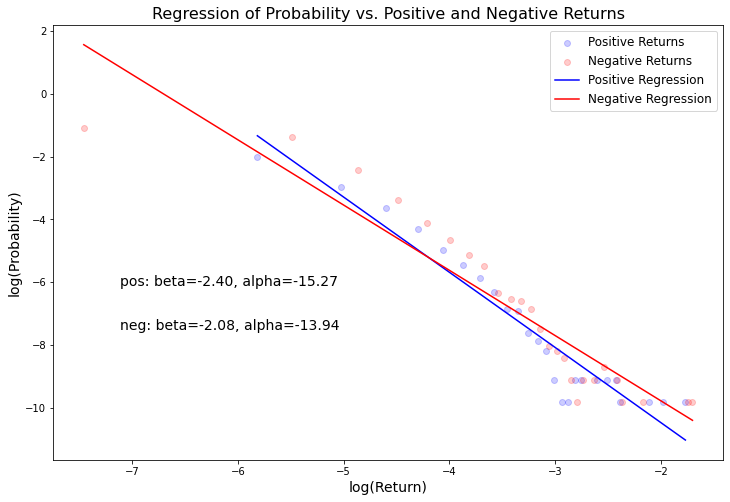

In [43]:
log_log_regression(filename, 'overall', ret_ranges=[(-1, 1)])

Positive Returns: beta=-0.436, alpha=-7.353
Negative Returns: beta=-0.827, alpha=-9.541


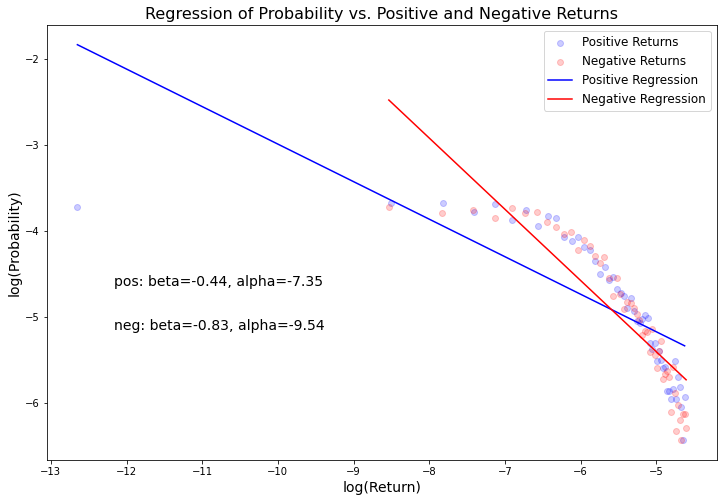

In [44]:
log_log_regression(filename, 'lnln0.01_0', ret_ranges=[(-1e-2, 1e-2)])

Positive Returns: beta=-267.736, alpha=-3.553
Negative Returns: beta=-283.922, alpha=-3.504


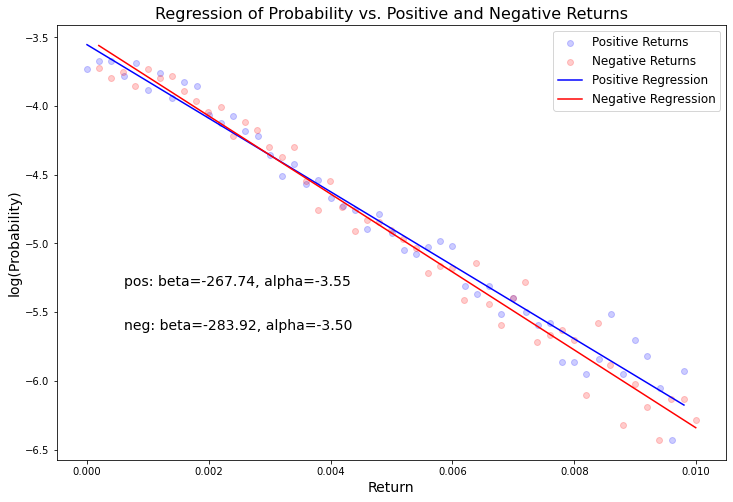

In [18]:
log_log_regression(filename, 'ln0.01_0', logx=False, ret_ranges=[(-0.01, 0.01)])

Negative Returns: beta=-2.398, alpha=-12.630
Positive Returns: beta=-2.432, alpha=-13.051


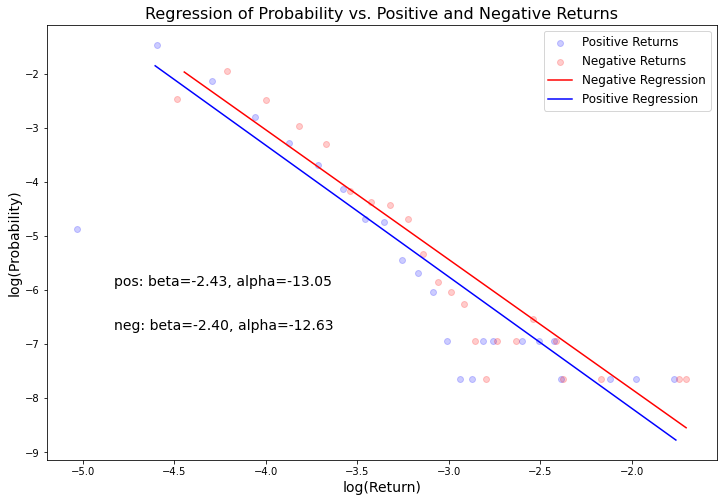

In [19]:
log_log_regression(filename, 'lnln0.01_1', ret_ranges=[(-1, -1e-2), (1e-2, 1)])

In [51]:
filename_1d = './exchange_data/BTC_1d_return.csv'

Positive Returns: beta=-1.022, alpha=-7.888
Negative Returns: beta=-1.455, alpha=-9.048


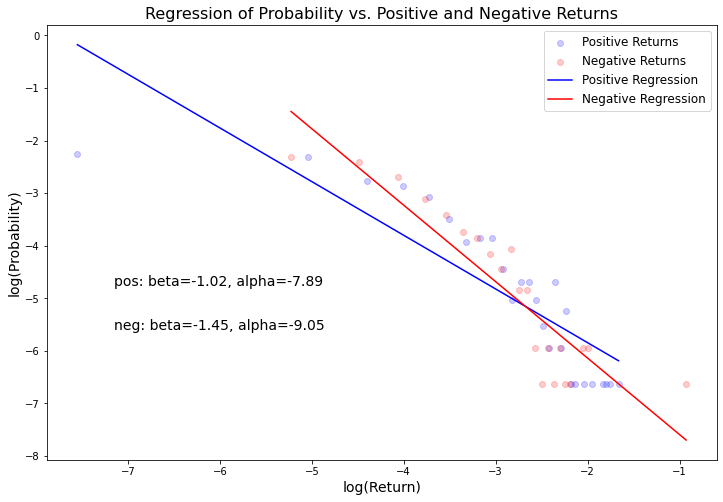

In [52]:
log_log_regression(filename_1d, 'a', ret_ranges=[(-1, 1)])

Positive Returns: beta=0.023, alpha=-4.475
Negative Returns: beta=0.013, alpha=-4.597


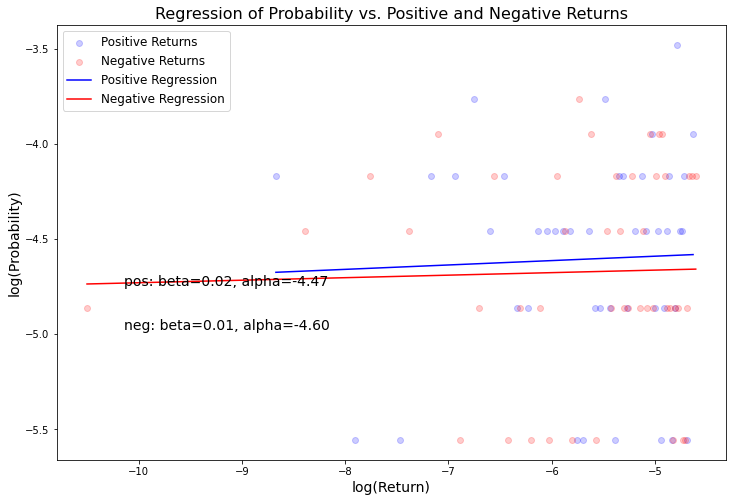

In [53]:
log_log_regression(filename_1d, 'a', ret_ranges=[(-0.01, 0.01)])

Positive Returns: beta=-33.123, alpha=-3.454
Negative Returns: beta=-38.831, alpha=-3.420


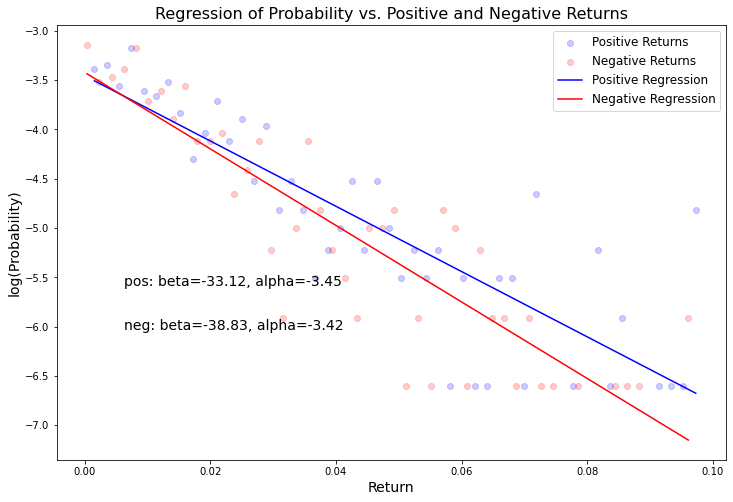

In [55]:
log_log_regression(filename_1d, 'a', logx=False, ret_ranges=[(-0.1, 0.1)])

Negative Returns: beta=-1.536, alpha=-8.306
Positive Returns: beta=-1.249, alpha=-8.160


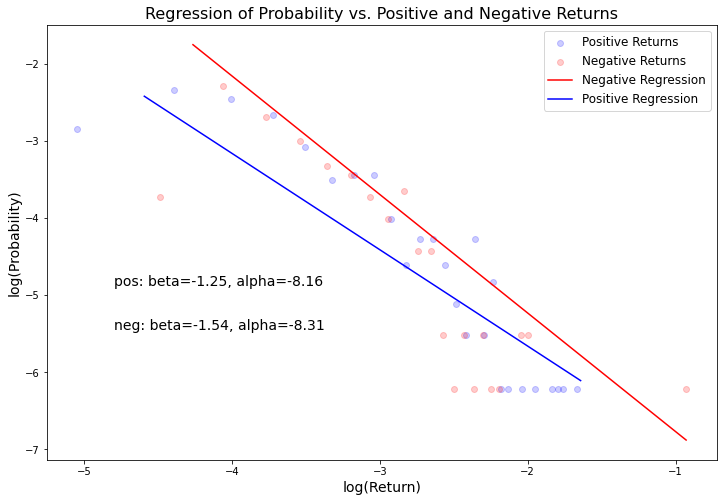

In [59]:
log_log_regression(filename_1d, 'a', ret_ranges=[(-1, -1e-2), (1e-2, 1)])